# **Enhanced-India-Centric-Stock-Sentiment-Analysis**



# **1-Data Pre-Processing : load + clean + split + balance**

In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter


**---------- Helpers ----------**

**Lightweight cleaning: remove URLs, HTML, extra whitespace, CR/LF**

In [ ]:
def clean_text(text: str) -> str:
    # Ensure input is a string, handle non-string types including NaN
    if not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove carriage returns/newlines/tabs
    text = re.sub(r"[\r\n\t]+", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

**Load dataset**

In [ ]:
def load_csv(path):
    df = pd.read_csv(path)
    df = df[["Headline", "Sentiment"]].dropna().drop_duplicates()
    df["Headline"] = df["Headline"].apply(clean_text)
    return df.reset_index(drop=True)

**Paths**

In [ ]:
paths = {
    "india": "/content/final_news_sentiment_analysis.csv",
    "djia": "/content/pro_djia.csv",
    "nasdaq": "/content/pro_nasdaq.csv",
    "financial_phrasebank": "/content/pro_all-data.csv",
    "stock_market": "/content/pro_stock_data.csv",
    "twitter_train": "/content/pro_sent_train.csv",
    "twitter_valid": "/content/pro_sent_valid.csv",
}

**Load datasets**




In [ ]:
india_df = load_csv(paths["india"])
external_df = pd.concat(
    [load_csv(paths[k]) for k in ["djia","nasdaq","financial_phrasebank","stock_market","twitter_train","twitter_valid"]],
    ignore_index=True
)
mixed_df = pd.concat([india_df, external_df], ignore_index=True)

print("India size:", india_df.shape)
print("External size:", external_df.shape)
print("Mixed size:", mixed_df.shape)


India size: (6645, 2)
External size: (34628, 2)
Mixed size: (41273, 2)


**Balance**

In [ ]:
def balance_dataset(df):
    # Drop NaNs in text column first
    df = df.dropna(subset=["Headline"])
    df["Headline"] = df["Headline"].astype(str).str.strip()

    min_count = df["Sentiment"].value_counts().min()
    parts = []
    for lbl in df["Sentiment"].unique():
        parts.append(df[df["Sentiment"] == lbl].sample(min_count, random_state=42))
    balanced_df = pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Balance each dataset
india_bal = balance_dataset(india_df)
external_bal = balance_dataset(external_df)
mixed_bal = balance_dataset(mixed_df)

# Check counts and head of balanced datasets
print("Balanced counts:")
print("India:", Counter(india_bal["Sentiment"]))
print(india_bal.head())
print("External:", Counter(external_bal["Sentiment"]))
print(external_bal.head())
print("Mixed:", Counter(mixed_bal["Sentiment"]))
print(mixed_bal.head())

Balanced counts:
India: Counter({'Positive': 1365, 'Neutral': 1365, 'Negative': 1365})
                                            Headline Sentiment
0  India stocks lower at close of trade; Nifty 50...  Positive
1  French cement giant Lafarge charged with compl...   Neutral
2  India's Mahindra says Fiat Chrysler files pate...  Negative
3  Exclusive: Uber says Didi deal frees resources...  Negative
4  A full-time workload increases risk of cancer,...  Negative
External: Counter({'Negative': 10879, 'Positive': 10879, 'Neutral': 10879})
                                            Headline Sentiment
0  Consumerist: Google Buys Domain Name That’s Al...  Negative
1  EPS from continuing operations came in at 0.30...  Positive
2  Michael Phelps Powers U.S. to Victory in 4x100...  Negative
3  `` It gives us a sense of pride and exposure ,...  Positive
4  UEFA Cup group stage match watch Hamburg vs As...  Positive
Mixed: Counter({'Negative': 12973, 'Positive': 12973, 'Neutral': 12973})
        

**Train/Test Split (80/20 stratified)**

In [ ]:
def stratified_split(df, test_size=0.2):
    return train_test_split(df, test_size=test_size, stratify=df["Sentiment"], random_state=42)

india_train, india_test = stratified_split(india_bal)
external_train, external_test = stratified_split(external_bal)
mixed_train, mixed_test = stratified_split(mixed_bal)


**Save**

In [ ]:
outdir = "/content/processed_splits"
os.makedirs(outdir, exist_ok=True)

india_train.to_csv(f"{outdir}/india_train.csv", index=False)
india_test.to_csv(f"{outdir}/india_test.csv", index=False)   # gold test set
external_train.to_csv(f"{outdir}/external_train.csv", index=False)
external_test.to_csv(f"{outdir}/external_test.csv", index=False)
mixed_train.to_csv(f"{outdir}/mixed_train.csv", index=False)
mixed_test.to_csv(f"{outdir}/mixed_test.csv", index=False)

print("\nSaved all balanced splits to:", outdir)


Saved all balanced splits to: /content/processed_splits


# **2.Baseline TF-IDF + Logistic Regression**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


In [ ]:
# Load gold test set (India)
outdir = "/content/processed_splits"
india_test = pd.read_csv(f"{outdir}/india_test.csv")

In [ ]:
# Reusable Evaluation Function
def evaluate_baseline(model, X_test, y_test, model_name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average="weighted")
    cm = confusion_matrix(y_test, preds, labels=["Positive","Neutral","Negative"])

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    print("Confusion Matrix:\n", cm)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [ ]:
# Training function
def train_and_eval(train_path, test_df, model_name):
    # Load dataset
    train_df = pd.read_csv(train_path)
    # Explicitly drop rows with NaN in 'Headline' before vectorization
    train_df = train_df.dropna(subset=["Headline"]).reset_index(drop=True)


    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(train_df["Headline"])
    y_train = train_df["Sentiment"]

    X_test = vectorizer.transform(test_df["Headline"])
    y_test = test_df["Sentiment"]

    # Train Logistic Regression
    clf = LogisticRegression(max_iter=300, class_weight="balanced")
    clf.fit(X_train, y_train)

    # Evaluate
    return evaluate_baseline(clf, X_test, y_test, model_name)

In [ ]:
# Run for India, External, Mixed
results = []
results.append(train_and_eval(f"{outdir}/india_train.csv", india_test, "Baseline India-only on India"))
results.append(train_and_eval(f"{outdir}/external_train.csv", india_test, "Baseline External-only on India"))
results.append(train_and_eval(f"{outdir}/mixed_train.csv", india_test, "Baseline Mixed on India"))
results.append(train_and_eval(f"{outdir}/external_train.csv", external_test, "Baseline External-only on External"))
results.append(train_and_eval(f"{outdir}/mixed_train.csv", mixed_test, "Baseline Mixed on Mixed"))


=== Baseline India-only on India ===
Accuracy: 0.375
Precision: 0.374, Recall: 0.375, F1: 0.374
Confusion Matrix:
 [[ 99  88  86]
 [ 84 115  74]
 [ 98  82  93]]

=== Baseline External-only on India ===
Accuracy: 0.333
Precision: 0.335, Recall: 0.333, F1: 0.332
Confusion Matrix:
 [[ 82  80 111]
 [ 72  85 116]
 [ 94  73 106]]

=== Baseline Mixed on India ===
Accuracy: 0.398
Precision: 0.425, Recall: 0.398, F1: 0.365
Confusion Matrix:
 [[ 54 173  46]
 [ 28 202  43]
 [ 35 168  70]]

=== Baseline External-only on External ===
Accuracy: 0.649
Precision: 0.648, Recall: 0.649, F1: 0.648
Confusion Matrix:
 [[1209  319  648]
 [ 272 1658  246]
 [ 526  278 1372]]

=== Baseline Mixed on Mixed ===
Accuracy: 0.615
Precision: 0.614, Recall: 0.615, F1: 0.613
Confusion Matrix:
 [[1398  538  659]
 [ 335 1864  396]
 [ 562  507 1525]]


In [ ]:
# Collect results in a DataFrame for comparison
results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)


=== Comparison Table ===
                                Model  Accuracy  Precision    Recall        F1
0        Baseline India-only on India  0.374847   0.374470  0.374847  0.374400
1     Baseline External-only on India  0.333333   0.335369  0.333333  0.332432
2             Baseline Mixed on India  0.398046   0.424599  0.398046  0.365365
3  Baseline External-only on External  0.649357   0.647706  0.649357  0.648053
4             Baseline Mixed on Mixed  0.614979   0.613671  0.614979  0.612867


# **3.Fine-tuning LLM**

In [ ]:
# Step 1: Downgrade PyArrow to avoid cuDF conflict
!pip uninstall -y pyarrow
!pip install pyarrow==19.0.0

# Step 2: Install required libraries
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft


Found existing installation: pyarrow 19.0.0
Uninstalling pyarrow-19.0.0:
  Successfully uninstalled pyarrow-19.0.0
  Using cached pyarrow-19.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 21.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 2

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**CONFIG**

In [ ]:
# Dataset paths
output_base_dir = "./bert_finetuned"
os.makedirs(output_base_dir, exist_ok=True)

dataset_paths = {
    "india_train": "./processed_splits/india_train.csv",
    "india_test": "./processed_splits/india_test.csv",
    "external_train": "./processed_splits/external_train.csv",
    "external_test": "./processed_splits/external_test.csv",
    "mixed_train": "./processed_splits/mixed_train.csv",
    "mixed_test": "./processed_splits/mixed_test.csv",
    "gold_test": "./processed_splits/india_test.csv"
}


***HELPER FUNCTIONS***

In [ ]:
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

In [ ]:
def clean_headlines(df, text_col="Headline", label_col="Sentiment"):
    # Drop rows missing text or labels
    df = df.dropna(subset=[text_col, label_col]).copy()

    # If some entries are lists/tuples of tokens, join them
    def to_text(x):
        if isinstance(x, (list, tuple)):
            return " ".join(map(str, x))
        if isinstance(x, str):
            return x
        if x is None:
            return ""
        return str(x)

    df[text_col] = df[text_col].apply(to_text).astype(str).str.strip()
    # Remove empty texts after strip (optional but helpful)
    df = df[df[text_col].ne("")]

    return df


**Tokenization function**

In [ ]:
def tokenize(batch):
    texts = batch["text"]
    # Ensure list
    if not isinstance(texts, list):
        texts = list(texts)
    # Normalize every element to a string
    norm_texts = []
    for t in texts:
        if isinstance(t, (list, tuple)):
            norm_texts.append(" ".join(map(str, t)))
        elif isinstance(t, str):
            norm_texts.append(t)
        elif t is None:
            norm_texts.append("")
        else:
            norm_texts.append(str(t))
    return tokenizer(
        norm_texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )


**Metrics**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

**Eval**

In [ ]:
def evaluate(y_true, y_pred):
    # Define labels and mapping to integers
    labels = ["Negative", "Neutral", "Positive"]
    mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}

    # Map string labels to integers
    y_true_mapped = np.vectorize(lambda x: mapping.get(x, 1))(y_true)
    y_pred_mapped = np.vectorize(lambda x: mapping.get(x, 1))(y_pred)

    # Accuracy
    accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
    print(f"\nAccuracy: {accuracy:.3f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_mapped, y_pred_mapped, target_names=labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=[0,1,2])
    print("\nConfusion Matrix:\n", conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

**PREDICTION PIPELINE**

In [ ]:
# Generate predictions using a classification model
def predict(test_df, model, tokenizer, device):
    model.to(device)
    model.eval()  # Ensure model is in evaluation mode

    # Tokenize all inputs at once
    encodings = tokenizer(
        list(test_df["text"]),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # (batch_size, num_labels)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

    # Map integer labels back to sentiment strings
    mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    y_pred = [mapping[p] for p in preds]
    return y_pred


**MODEL LOADING**

In [ ]:
# Load BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**TRAINING & EVALUATION LOOP**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training on india dataset =====


Map:   0%|          | 0/3276 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Step,Training Loss
100,1.105900
200,1.081600
300,0.904100
400,0.669800
500,0.480200
600,0.399500
700,0.357900
800,0.313500
900,0.313600
1000,0.293300



Accuracy: 0.398

Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.32      0.36       273
     Neutral       0.42      0.41      0.41       273
    Positive       0.38      0.47      0.42       273

    accuracy                           0.40       819
   macro avg       0.40      0.40      0.40       819
weighted avg       0.40      0.40      0.40       819


Confusion Matrix:
 [[ 86  74 113]
 [ 62 113  98]
 [ 61  85 127]]


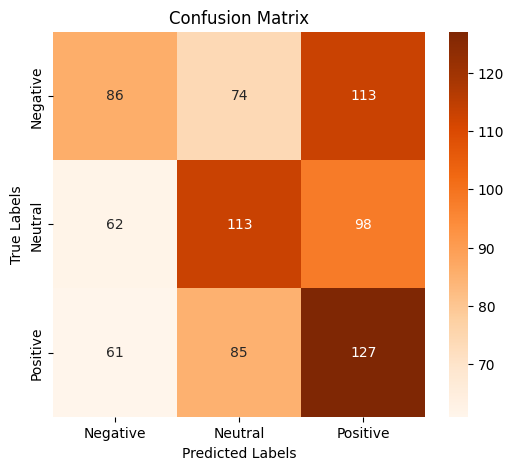

Map:   0%|          | 0/819 [00:00<?, ? examples/s]


Accuracy: 0.398

Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.32      0.36       273
     Neutral       0.42      0.41      0.41       273
    Positive       0.38      0.47      0.42       273

    accuracy                           0.40       819
   macro avg       0.40      0.40      0.40       819
weighted avg       0.40      0.40      0.40       819


Confusion Matrix:
 [[ 86  74 113]
 [ 62 113  98]
 [ 61  85 127]]


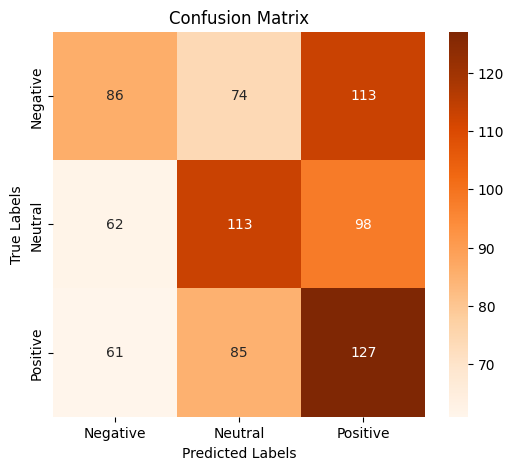

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training on external dataset =====


Map:   0%|          | 0/26094 [00:00<?, ? examples/s]

Map:   0%|          | 0/6525 [00:00<?, ? examples/s]

Step,Training Loss
100,0.952000
200,0.767900
300,0.698700
400,0.672300
500,0.642500
600,0.519100
700,0.467000
800,0.495600
900,0.478200
1000,0.481400



Accuracy: 0.736

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.72      0.69      2174
     Neutral       0.86      0.85      0.85      2176
    Positive       0.68      0.64      0.66      2175

    accuracy                           0.74      6525
   macro avg       0.74      0.74      0.74      6525
weighted avg       0.74      0.74      0.74      6525


Confusion Matrix:
 [[1563  126  485]
 [ 165 1839  172]
 [ 599  175 1401]]


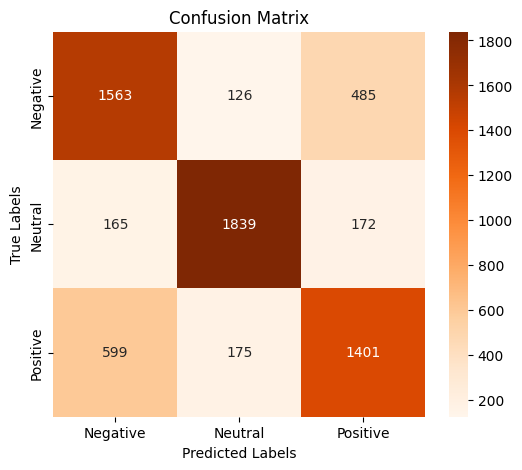

Map:   0%|          | 0/819 [00:00<?, ? examples/s]


Accuracy: 0.320

Classification Report:
              precision    recall  f1-score   support

    Negative       0.28      0.33      0.30       273
     Neutral       0.35      0.31      0.33       273
    Positive       0.34      0.32      0.33       273

    accuracy                           0.32       819
   macro avg       0.32      0.32      0.32       819
weighted avg       0.32      0.32      0.32       819


Confusion Matrix:
 [[ 89  84 100]
 [119  85  69]
 [114  71  88]]


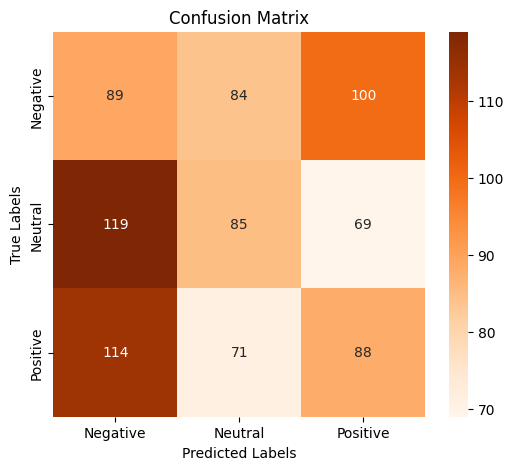

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Training on mixed dataset =====


Map:   0%|          | 0/31124 [00:00<?, ? examples/s]

Map:   0%|          | 0/7776 [00:00<?, ? examples/s]

Step,Training Loss
100,1.007500
200,0.867600
300,0.804000
400,0.776900
500,0.765300
600,0.730600
700,0.651700
800,0.573800
900,0.588800
1000,0.586400



Accuracy: 0.680

Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.63      0.64      2588
     Neutral       0.73      0.78      0.76      2593
    Positive       0.65      0.63      0.64      2595

    accuracy                           0.68      7776
   macro avg       0.68      0.68      0.68      7776
weighted avg       0.68      0.68      0.68      7776


Confusion Matrix:
 [[1641  368  579]
 [ 272 2019  302]
 [ 600  365 1630]]


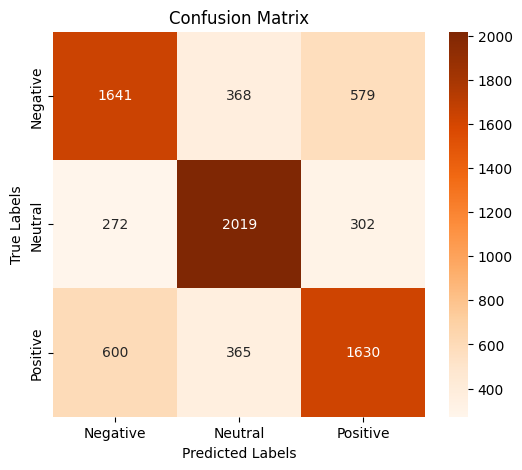

Map:   0%|          | 0/819 [00:00<?, ? examples/s]


Accuracy: 0.702

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.60      0.71       273
     Neutral       0.56      0.90      0.69       273
    Positive       0.88      0.60      0.72       273

    accuracy                           0.70       819
   macro avg       0.77      0.70      0.70       819
weighted avg       0.77      0.70      0.70       819


Confusion Matrix:
 [[165  99   9]
 [ 15 245  13]
 [ 12  96 165]]


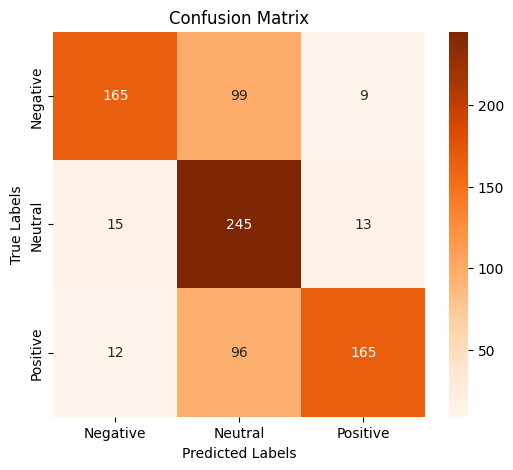

In [ ]:
results = []

for split_name in ["india", "external", "mixed"]:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
    print(f"\n===== Training on {split_name} dataset =====")

    # Load & clean train data
    df_train = pd.read_csv(dataset_paths[f"{split_name}_train"])
    df_train = clean_headlines(df_train, text_col="Headline", label_col="Sentiment")
    df_train["Sentiment"] = df_train["Sentiment"].str.title().str.strip()  # normalize, if needed
    df_train["labels"] = df_train["Sentiment"].map(label_map).astype(int)

    train_dataset = Dataset.from_pandas(df_train[["Headline", "labels"]])
    train_dataset = train_dataset.rename_column("Headline", "text")
    train_dataset = train_dataset.map(tokenize, batched=True)
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Load & clean test data
    df_test = pd.read_csv(dataset_paths[f"{split_name}_test"])
    df_test = clean_headlines(df_test, text_col="Headline", label_col="Sentiment")
    df_test["Sentiment"] = df_test["Sentiment"].str.title().str.strip()
    df_test["labels"] = df_test["Sentiment"].map(label_map).astype(int)

    test_dataset = Dataset.from_pandas(df_test[["Headline", "labels"]])
    test_dataset = test_dataset.rename_column("Headline", "text")
    test_dataset = test_dataset.map(tokenize, batched=True)
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


    # Ensure pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.cls_token

    # Training arguments
    training_args = TrainingArguments(
    output_dir=f"{output_base_dir}/{split_name}",
    num_train_epochs=16,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=3,
    learning_rate=5e-5,
    logging_steps=100,
    fp16=True,
    save_total_limit=2,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    logging_dir=f"{output_base_dir}/{split_name}/logs",
    report_to=["tensorboard"],
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        processing_class=tokenizer,  # instead of tokenizer=...
        compute_metrics=compute_metrics
    )
    # Train
    trainer.train()
    trainer.save_model(f"{output_base_dir}/{split_name}/final_model")
    tokenizer.save_pretrained(f"{output_base_dir}/{split_name}/final_tokenizer")

    # Evaluate on split test
    logits = trainer.predict(test_dataset).predictions
    y_pred_split = np.argmax(logits, axis=-1)
    y_true_split = df_test["labels"].values
    y_pred_split_labels = [list(label_map.keys())[list(label_map.values()).index(i)] for i in y_pred_split]
    y_true_split_labels = [list(label_map.keys())[list(label_map.values()).index(i)] for i in y_true_split]
    evaluate(y_true_split_labels, y_pred_split_labels)

    # Evaluate on gold test
    gold_df = pd.read_csv(dataset_paths["gold_test"])
    gold_df["labels"] = gold_df["Sentiment"].map(label_map)
    gold_dataset = Dataset.from_pandas(gold_df[["Headline", "labels"]])
    gold_dataset = gold_dataset.rename_column("Headline", "text")
    gold_dataset = gold_dataset.map(tokenize, batched=True)
    gold_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    logits_gold = trainer.predict(gold_dataset).predictions
    y_pred_gold = np.argmax(logits_gold, axis=-1)
    y_true_gold = gold_df["labels"].values
    y_pred_gold_labels = [list(label_map.keys())[list(label_map.values()).index(i)] for i in y_pred_gold]
    y_true_gold_labels = [list(label_map.keys())[list(label_map.values()).index(i)] for i in y_true_gold]
    evaluate(y_true_gold_labels, y_pred_gold_labels)

    # Save results
    results.append({
        "Model": split_name,
        "Split_Accuracy": accuracy_score(y_true_split, y_pred_split),
        "Split_F1": f1_score(y_true_split, y_pred_split, average="weighted"),
        "Gold_Accuracy": accuracy_score(y_true_gold, y_pred_gold),
        "Gold_F1": f1_score(y_true_gold, y_pred_gold, average="weighted")
    })


# **4.FINAL RESULTS TABLE**

In [ ]:
results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)
results_df.to_csv(f"{output_base_dir}/model_comparison.csv", index=False)


=== Comparison Table ===
      Model  Split_Accuracy  Split_F1  Gold_Accuracy   Gold_F1
0     india        0.398046  0.395746       0.398046  0.395746
1  external        0.736092  0.736235       0.319902  0.320873
2     mixed        0.680298  0.679126       0.702076  0.704769
